<a href="https://colab.research.google.com/github/lmcdo/creditcardfraudWeek3/blob/master/credicardtfraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pwd

/content


In [0]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv("creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

Using TensorFlow backend.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset consists of 28 anonymized variables, 1 "amount" variable, 1 "time" variable and 1 target variable - Class. Let's look at the distribution of target.

Semi Supervised Classification using AutoEncoders
Introduction
By definition, machine learning can be defined as a complex process of learning the best possible and most relevant patterns, relationships, or associations from a dataset which can be used to predict the outcomes on unseen data. Broadly, their exists three different machine learning processes:

1. Supervised Learning is a process of training a machine learning model on a labelled dataset ie. a dataset in which the target variable is known. In this technique, the model aims to find the relationships among the independent and dependent variable. Examples of supervised learning are classification, regression and forecasting. 

2. Unsupervised Learning is a process of training a machine learning model on a dataset in which target variable is not known. In this technique, the model aims to find the most relevant patterns in the data or the segments of data. Examples of unsupervised learning are clustering, segmentations, dimensionality reduction etc. 

3. Semi-Supervised Learning is combination of supervised and unsupervised learning processes in which the unlabelled data is used for training a model as well. In this approach, the properties of unspervised learning are used to learn the best possible representation of data and the properties of supervised learning are used to learn the relationships in the representations which are then used to make predictions.

In this kernel, I have explained how to perform classification task using semi supervised learning approach. This approach makes use of autoencoders to learn the representation of the data then a simple linear classifier is trained to classify the dataset into respective classes.



Fraud Detection using Semi Supervised Learning
I am using the dataset of Credit Card Fraud Detection by ULB machine learning group. Later, I am also applying the same technique on Titanic dataset. A number of kagglers have shared different approaches such as dataset balancing, anomaly detection, boosting models, deep learning etc but this approach is different.

Contents
Dataset Preparation
Visualize Fraud Vs Non Fraud Transactions
AutoEncoders : Latent Representation Extraction
Obtain the Latent Representations
Visualize Latent Representations : Fraud vs Non Fraud
Simple Linear Classifier

# 1. Dataset Preparation

In [0]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


For our use-case let's take only about 1000 rows of non-fraud transactions.

In [0]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

Every dot in the following represents a transaction. Non Fraud transactions are represented as Green while Fraud transactions are represented as Red. The two axis are the components extracted by tsne.

## 2. Visualize Fraud and NonFraud Transactions

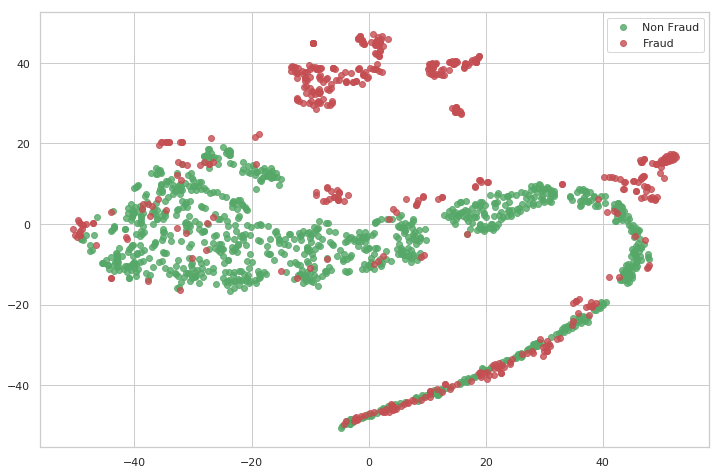

In [0]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

Here we have used Seaborn to override MatplotLib plotting to visualise the TSNE model's output of the data

We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

Create a network with one input layer and one output layer having identical dimentions ie. the shape of non-fraud cases. We will use keras package.

## 3. Use an AutoEncoder

In [0]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

Create the model architecture by compiling input layer and output layers. Also add the optimizer and loss function, I am using "adadelta" as the optimizer and "mse" as the loss function.



In [0]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse") 

Before training, let's perform min max scaling.

In [0]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

We will use only 2000 rows of non fraud cases to train the autoencoder. 

Additionally, We do not need to run this model for a large number of epochs.

Explanation: The choice of small samples from the original dataset is based on the intuition that one class characteristics (non fraud) will differ from that of the other (fraud). To distinguish these characteristics we need to show the autoencoders only one class of data. This is because the autoencoder will try to learn only one class and automaticlly distinuish the other class.



In [0]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);



Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 4s 3ms/step - loss: 0.7410 - val_loss: 0.5062
Epoch 2/10
1600/1600 [==============================] - 0s 30us/step - loss: 0.4766 - val_loss: 0.3405
Epoch 3/10
1600/1600 [==============================] - 0s 29us/step - loss: 0.3199 - val_loss: 0.2230
Epoch 4/10
1600/1600 [==============================] - 0s 28us/step - loss: 0.1972 - val_loss: 0.1444
Epoch 5/10
1600/1600 [==============================] - 0s 31us/step - loss: 0.1525 - val_loss: 0.1381
Epoch 6/10
1600/1600 [==============================] - 0s 31us/step - loss: 0.1595 - val_loss: 0.1378
Epoch 7/10
1600/1600 [==============================] - 0s 29us/step - loss: 0.1513 - val_loss: 0.1266
Epoch 8/10
1600/1600 [==============================] - 0s 29us/step - loss: 0.1344 - val_loss: 0.1274
Epoch 9/10
1600/1600 [==============================] - 0s 29us/step - loss: 0.1470 - val_loss: 0.1218
Epoch 10/10
1600/1600 [==

Now, the model is trained. We are intereseted in obtaining latent representation of the input learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and we will only add the trained weights till the third layer where latent representation exists.

## 4. Obtain the Latent Representations

In [0]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Generate the hidden representations of two classes : non-fraud and fraud by predicting the raw inputs using the above model.

In [0]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

## 5. Visualize the latent representations : Fraud Vs Non Fraud
Now we will create a training dataset using the latent representations obtained and let's visualize the nature of fraud vs non-fraud cases.

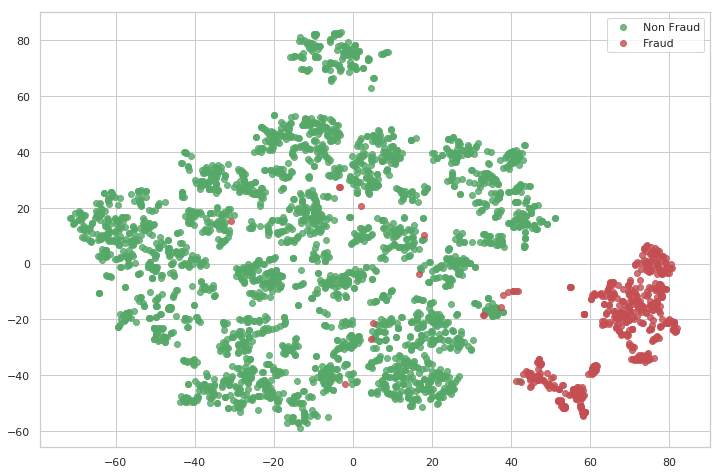

In [0]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

Now, we can just train a simple linear classifier on the dataset.

# 6. Simple Linear Classifier

In [0]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       754
         1.0       1.00      0.87      0.93       119

    accuracy                           0.98       873
   macro avg       0.99      0.93      0.96       873
weighted avg       0.98      0.98      0.98       873


Accuracy Score:  0.981672394043528


# Seaborn plot: